In [19]:
# Django setup and imports
import os
import sys
import django
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Add project root to Python path
project_root = Path.cwd()
sys.path.insert(0, str(project_root))

# Set Django settings module
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'TradeLens.settings')
os.environ.setdefault('DJANGO_ALLOW_ASYNC_UNSAFE', 'true')

# Configure Django
django.setup()

print("Django configured successfully!")

Django configured successfully!


In [20]:
# Import entity service and UMAP
from shared_utils.entities.service.EntityService import EntityService
from shared_utils.entities.EntityModel import EntityModel
from shared_utils.entities.service.embedding_model import _embed_sync
import umap

entity_service = EntityService()
all_models = EntityModel.objects.all()
print(f"✓ Entity service initialized with {len(all_models)} total models")

✓ Entity service initialized with 491 total models


In [21]:
# Extract embeddings and entity types for UMAP analysis
embeddings = []
entity_types = []
entity_ids = []
valid_models = []

print("Extracting embeddings and entity types for all entities...")

for model in all_models:
    if model.embedding is not None:
        embeddings.append(model.embedding)
        entity_types.append(model.entity_type)
        entity_ids.append(str(model.entity_id))
        valid_models.append(model)

# Convert to numpy arrays
embeddings_array = np.array(embeddings)
entity_types_array = np.array(entity_types)

print(f"=== ENTITY DATA SUMMARY ===")
print(f"Total models in database: {len(all_models)}")
print(f"Models with valid embeddings: {len(embeddings)}")
print(f"Embedding dimensions per entity: {embeddings_array.shape[1]}")

print(f"\n=== ENTITY TYPE BREAKDOWN ===")
unique, counts = np.unique(entity_types_array, return_counts=True)
for entity_type, count in zip(unique, counts):
    print(f"  {entity_type}: {count} entities")

print(f"\nReady for UMAP analysis with {len(embeddings)} entities")

Extracting embeddings and entity types for all entities...
=== ENTITY DATA SUMMARY ===
Total models in database: 491
Models with valid embeddings: 343
Embedding dimensions per entity: 384

=== ENTITY TYPE BREAKDOWN ===
  : 2 entities
  api_model: 2 entities
  document: 136 entities
  meal_plan: 3 entities
  recipe: 6 entities
  training_session: 1 entities
  view: 193 entities

Ready for UMAP analysis with 343 entities


In [26]:
# Perform UMAP 2D dimensionality reduction
print("Performing UMAP 2D reduction...")

# Apply UMAP directly to embeddings (no scaling needed with cosine metric)
umap_2d = umap.UMAP(
    n_components=2,
    n_neighbors=15,     # Balance between local and global structure
    min_dist=0.1,       # Minimum distance between points
    metric='cosine',    # Good for embeddings - inherently scale-invariant
    random_state=42
)

embeddings_umap_2d = umap_2d.fit_transform(embeddings_array)

print(f"✓ UMAP 2D completed without scaling!")
print(f"✓ Reduced embeddings shape: {embeddings_umap_2d.shape}")

# Create DataFrame for UMAP plotting
df_umap = pd.DataFrame({
    'UMAP1': embeddings_umap_2d[:, 0],
    'UMAP2': embeddings_umap_2d[:, 1],
    'entity_type': entity_types_array,
    'entity_id': entity_ids
})

print(f"✓ Created UMAP DataFrame with {len(df_umap)} entities")
print(f"✓ Ready for visualization and query analysis")

Performing UMAP 2D reduction...
✓ UMAP 2D completed without scaling!
✓ Reduced embeddings shape: (343, 2)
✓ Created UMAP DataFrame with 343 entities
✓ Ready for visualization and query analysis


Creating UMAP 2D visualization...


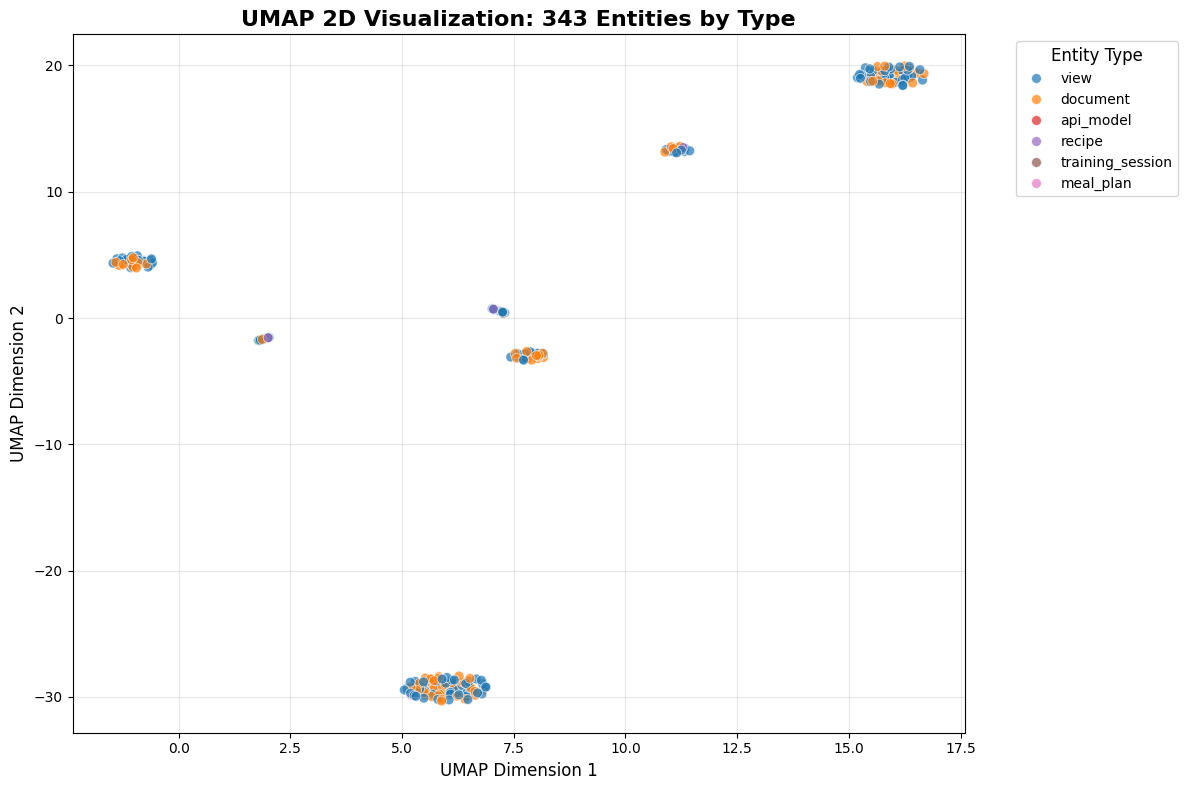

✓ UMAP 2D visualization completed!
✓ Total points plotted: 343 entities
✓ Each point represents one entity, colored by its type
✓ Close points = similar embeddings = semantically similar entities


In [27]:
# Create UMAP 2D visualization
print("Creating UMAP 2D visualization...")

plt.figure(figsize=(12, 8))

# Create scatter plot with entities colored by type
sns.scatterplot(data=df_umap, x='UMAP1', y='UMAP2', hue='entity_type', alpha=0.7, s=50)

plt.title(f'UMAP 2D Visualization: {len(df_umap)} Entities by Type', fontsize=16, fontweight='bold')
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)

# Improve legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Entity Type', title_fontsize=12)

# Add grid for better readability
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✓ UMAP 2D visualization completed!")
print(f"✓ Total points plotted: {len(df_umap)} entities")
print(f"✓ Each point represents one entity, colored by its type")
print(f"✓ Close points = similar embeddings = semantically similar entities")


In [28]:
# Define query embedding and visualization function
def embed_query_and_visualize(query_text, plot_title="Query in UMAP Space"):
    """
    Embed a user query and visualize it in the same UMAP space as entity embeddings
    
    Args:
        query_text (str): The text to embed and visualize
        plot_title (str): Title for the plot
    """
    print(f"Embedding query: '{query_text}'")
    
    # 1. Embed the query using the same model as entities
    query_embedding = _embed_sync([query_text])  # Returns list[list[float]]
    query_embedding_array = np.array(query_embedding)  # Shape: (1, 384)
    
    print(f"✓ Query embedded to {query_embedding_array.shape[1]} dimensions")
    
    # 2. Transform query embedding using the existing fitted UMAP model (no scaling)
    query_umap_2d = umap_2d.transform(query_embedding_array)  # Shape: (1, 2)
    
    print("✓ Query embedding projected to UMAP 2D space (unscaled)")
    
    # 3. Create visualization combining entities and query
    plt.figure(figsize=(14, 10))
    
    # Plot existing entities (same as before)
    sns.scatterplot(data=df_umap, x='UMAP1', y='UMAP2', hue='entity_type', 
                    alpha=0.6, s=50, legend='full')
    
    # Plot the query point with a distinctive marker
    plt.scatter(query_umap_2d[0, 0], query_umap_2d[0, 1], 
                color='red', s=200, marker='*', 
                edgecolors='black', linewidth=2,
                label=f'Query: "{query_text}"', zorder=10)
    
    # Enhance the plot
    plt.title(f'{plot_title}\nQuery: "{query_text}"', fontsize=16, fontweight='bold')
    plt.xlabel('UMAP Dimension 1', fontsize=12)
    plt.ylabel('UMAP Dimension 2', fontsize=12)
    
    # Improve legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Entity Type / Query')
    plt.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 4. Find nearest entities based on cosine similarity in original embedding space
    print(f"\n=== QUERY ANALYSIS ===")
    print(f"Query position in UMAP space: ({query_umap_2d[0, 0]:.3f}, {query_umap_2d[0, 1]:.3f})")
    
    # Calculate cosine similarity with all entities in original embedding space
    from sklearn.metrics.pairwise import cosine_similarity
    similarities = cosine_similarity(query_embedding_array, embeddings_array).flatten()
    
    # Find 5 most similar entities (highest cosine similarity)
    nearest_indices = np.argsort(similarities)[::-1][:5]
    
    print(f"\n🎯 Top 5 most similar entities to query '{query_text}' (cosine similarity on unscaled embeddings):")
    for i, idx in enumerate(nearest_indices):
        entity_type = entity_types_array[idx]
        entity_id = entity_ids[idx]
        similarity = similarities[idx]
        entity = entity_service.get_entity(entity_id)
        print(f"  {i+1}. Entity ID: {entity_id} | Type: {entity_type} | Cosine Similarity: {similarity:.3f}")
        print(str(entity.embidify()))
        print("\n")
    
    return query_umap_2d, nearest_indices

print("✓ Query embedding and visualization function defined!")
print("📘 Usage: embed_query_and_visualize('your search query here')")
print("📘 Now uses cosine similarity on unscaled embeddings for better semantic matching!")


✓ Query embedding and visualization function defined!
📘 Usage: embed_query_and_visualize('your search query here')
📘 Now uses cosine similarity on unscaled embeddings for better semantic matching!


In [36]:
import json

entity_service = EntityService()
doc = entity_service.get_entity("b3027e23-6f32-4afc-8917-6a5fa7134ed2")
q = json.dumps(doc.embidify())

print(len(q))

{'text': '"I see how we can release it to the world. Holy shit. If it was completely decentralized, the government would lose all power. Everything would be done over the network. But it\'s, you know, it goes back to you gotta have... Usability. You gotta build apps that people want to use. Like, you have to... A cooking app is cool. I don\'t need it in my life. I\'ll be fine without it. But if you built a net... I mean, I don\'t want to say network again, but if you built a series of those little apps, and you tied them together and made them all work together, like, you wouldn\'t use it for one thing. What if I start sending you links... to this format that you gotta open up? If you open it on your phone, you know... You could do a social media on it."', 'vector': 'null', 'document_type': 'null', 'processed_text': '""', 'tokens': '[]', 'hidden': 'false', 'name': '"Decentralization Thoughts"', 'width': '253', 'height': '195', 'position': '{"x": -707.8553433268517, "y": -739.9794599805

🚀 EMBEDDING USER QUERY IN ENTITY SPACE
Embedding query: '{"entity_name": "document", "attributes": {"text": "\"I see how we can release it to the world. Holy shit. If it was completely decentralized, the government would lose all power. Everything would be done over the network. But it's, you know, it goes back to you gotta have... Usability. You gotta build apps that people want to use. Like, you have to... A cooking app is cool. I don't need it in my life. I'll be fine without it. But if you built a net... I mean, I don't want to say network again, but if you built a series of those little apps, and you tied them together and made them all work together, like, you wouldn't use it for one thing. What if I start sending you links... to this format that you gotta open up? If you open it on your phone, you know... You could do a social media on it.\"", "vector": "null", "document_type": "null", "processed_text": "\"\"", "tokens": "[]", "hidden": "false", "name": "\"Decentralization Thoug

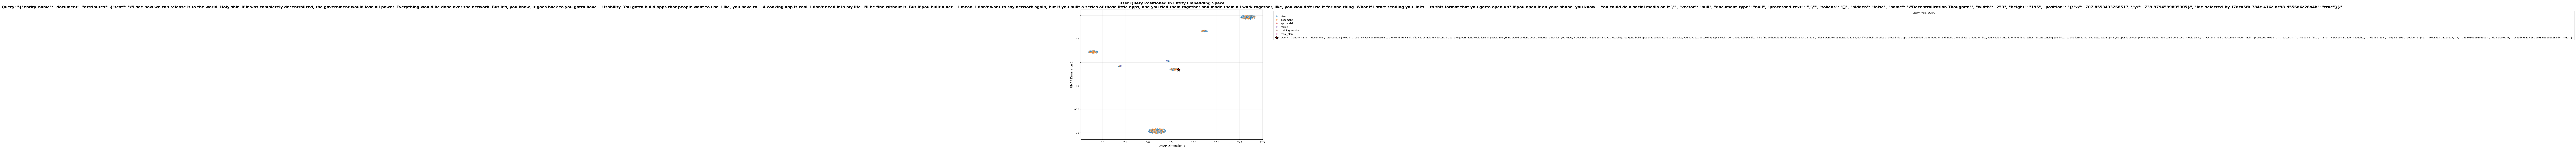


=== QUERY ANALYSIS ===
Query position in UMAP space: (8.328, -3.189)

🎯 Top 5 most similar entities to query '{"entity_name": "document", "attributes": {"text": "\"I see how we can release it to the world. Holy shit. If it was completely decentralized, the government would lose all power. Everything would be done over the network. But it's, you know, it goes back to you gotta have... Usability. You gotta build apps that people want to use. Like, you have to... A cooking app is cool. I don't need it in my life. I'll be fine without it. But if you built a net... I mean, I don't want to say network again, but if you built a series of those little apps, and you tied them together and made them all work together, like, you wouldn't use it for one thing. What if I start sending you links... to this format that you gotta open up? If you open it on your phone, you know... You could do a social media on it.\"", "vector": "null", "document_type": "null", "processed_text": "\"\"", "tokens": "[]"

In [35]:
# Example: Embed and visualize a user query
# user_query = "documents telling us about the future of the blockchain"
user_query = q
print("🚀 EMBEDDING USER QUERY IN ENTITY SPACE")
print("=" * 50)

# Use the function to embed and visualize the query
query_position, nearest_entities = embed_query_and_visualize(
    user_query, 
    plot_title="User Query Positioned in Entity Embedding Space"
)

print(f"\n💡 INTERPRETATION:")
print(f"The red star shows where your query '{user_query}' lands in the entity embedding space.")
print(f"Entities closest to the star are most semantically similar to your query!")
print(f"This helps you understand which entities in your database are most relevant to the search.")


Creating scatter plot with 343 points (one per entity)...


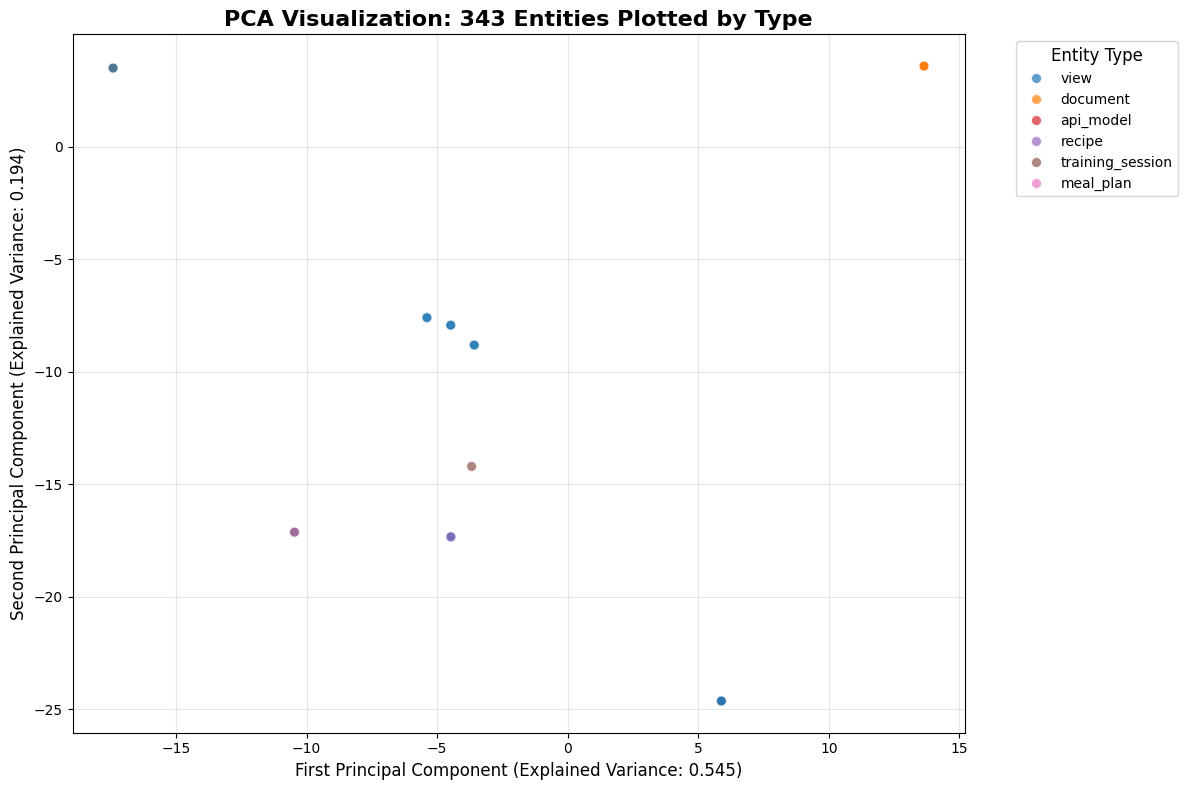

✓ Scatter plot completed!
✓ Total points plotted: 343 (= number of entities with embeddings)
✓ Entity types shown: 7
✓ Each point represents exactly ONE entity, colored by its entity_type
   - view: 193 points
   - document: 136 points
   - : 2 points
   - api_model: 2 points
   - recipe: 6 points
   - training_session: 1 points
   - meal_plan: 3 points


In [8]:
# Interactive query testing - Try different queries!
print("🔍 INTERACTIVE QUERY TESTING")
print("=" * 40)
print("Try different queries to see where they land in your entity space!")
print()

# Pre-defined test queries for exploration
test_queries = [
    "recipe cooking food preparation",
    "document analysis text processing", 
    "data visualization and charts",
    "user interface design",
    "machine learning model training"
]

print("📝 Pre-defined test queries:")
for i, query in enumerate(test_queries, 1):
    print(f"  {i}. '{query}'")

print(f"\n🎯 To test a query, use:")
print(f"embed_query_and_visualize('your query here')")
print(f"\n💡 Example:")
print(f"embed_query_and_visualize('{test_queries[0]}')")

print(f"\n✨ TIP: Modify the 'user_query' variable in the cell above to test different searches!")

# Uncomment the line below to automatically test the first query
# embed_query_and_visualize(test_queries[0])
